### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import os

import datetime
from datetime import date, timedelta

from tqdm.notebook import tqdm

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline

e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = os.path.join('..','OD')

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

def read_OD_fn(source_type):
    ods = {}
    for date in tqdm(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [3]:
ine_ods = read_OD_fn('INE')
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [4]:
lista_twt = []

for date in tqdm(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [6]:
print(df_twt.index.min())
print(df_ine.index.max())

print(len(df_twt['2020']))

print(len(df_ine['2020']))

2020-04-01 00:00:00
2020-06-20 00:00:00
81
81


C:\Users\ucam\AppData\Local\Temp/ipykernel_13752/2613588803.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(len(df_twt['2020']))
C:\Users\ucam\AppData\Local\Temp/ipykernel_13752/2613588803.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(len(df_ine['2020']))


In [7]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [8]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [9]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [10]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


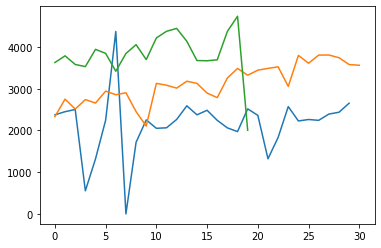

In [11]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

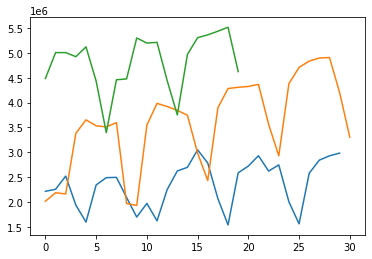

In [12]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [13]:
dataset_twt = df_twt.values
dataset_twt = dataset_twt.astype('float32')

dataset_ine = df_ine.values
dataset_ine = dataset_ine.astype('float32')

In [14]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


In [15]:
df_ine.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Dividimos los datos en sets de entrenamiento y validacion

In [16]:
nobs=7

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train_twt = dataset_twt[:n_train_days, :]
test_twt = dataset_twt[n_train_days:, :]

train_ine = dataset_ine[:n_train_days, :]
test_ine = dataset_ine[n_train_days:, :]

print(len(train_twt), len(test_twt))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset1, dataset2, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

# dividimos en entradas y salidas
look_back = 7
trainX, trainY = create_dataset(train_twt, train_ine, look_back)
testX, testY = create_dataset(test_twt, test_ine, look_back)

print(len(trainX), len(testY))

53 14


### Cointegration test

Dataframe with the scaled trips

In [19]:
trips_df = df_twt.copy()
trips_df['ine_trips']= df_ine['Viajes']
trips_df.head()

,Viajes,ine_trips
2020-04-01,2375,2213123
2020-04-02,2450,2254121
2020-04-03,2503,2520095
2020-04-04,554,1934554
2020-04-05,1319,1593385


In [63]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,7)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    print(out.trace_stat)

In [64]:
cointegration_test(trips_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Viajes ::  16.52     > 12.3212   =>   True
ine_trips ::  0.04      > 4.1296    =>   False
[16.51836923  0.04226512]


### Granger test

In [23]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(trips_df, variables = trips_df.columns)

,Viajes_x,ine_trips_x
Viajes_y,1.0,0.0
ine_trips_y,0.0,1.0


### Check stationarity

In [24]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [25]:
adfuller_test(trips_df['Viajes'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3798
 No. Lags Chosen       = 4
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.5919. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [28]:
adfuller_test(trips_df['ine_trips'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6251
 No. Lags Chosen       = 6
 Critical value 1%     = -3.522
 Critical value 5%     = -2.901
 Critical value 10%    = -2.588
 => P-Value = 0.9882. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [29]:
trips_df_differenced = trips_df.diff().dropna()

In [30]:
adfuller_test(trips_df_differenced['Viajes'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0413
 No. Lags Chosen       = 3
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [31]:
adfuller_test(trips_df_differenced['ine_trips'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.2264
 No. Lags Chosen       = 5
 Critical value 1%     = -3.522
 Critical value 5%     = -2.901
 Critical value 10%    = -2.588
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


### Select order for VAR Model

In [32]:
trips_df_differenced.columns

Index(['Viajes', 'ine_trips'], dtype='object')

In [33]:
model = VAR(trips_df_differenced)

C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [34]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,38.92,38.99,8.015e+16,38.95
1,38.97,39.16,8.371e+16,39.04
2,38.79,39.11,6.991e+16,38.91
3,38.66,39.11,6.160e+16,38.84
4,38.50,39.09,5.282e+16,38.74
5,38.09,38.81,3.523e+16,38.38
6,37.61,38.46*,2.175e+16,37.95*
7,37.57*,38.55,2.104e+16*,37.96
8,37.65,38.76,2.288e+16,38.09
9,37.71,38.95,2.464e+16,38.20


Best lag is set to 7 days

In [35]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Sep, 2021
Time:                     10:19:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    38.5584
Nobs:                     73.0000    HQIC:                   37.9923
Log likelihood:          -1550.19    FPE:                2.19827e+16
AIC:                      37.6172    Det(Omega_mle):     1.51273e+16
--------------------------------------------------------------------
Results for equation Viajes
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              125.147282        54.893716            2.280           0.023
L1.Viajes           -0.733587         0.131761           -5.568           0.000
L1.ine_trips        -0.000157         0.000134           -1.174

### Forecast test

In [36]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid, y_hat):
    mae_ = mean_absolute_error(y_valid, y_hat)
    mse_ = mean_squared_error(y_valid, y_hat)
    rmse_ = mean_squared_error(y_valid, y_hat, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid)*100 # it is a percentage
    mape_ = mape(y_valid, y_hat)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [37]:
trips_df.shape

(81, 2)

In [38]:
ine_true = []
ine_hat = []
for i in range(60, 81-7):
    X= trips_df.iloc[0:i]
    X_differenced = X.diff().dropna()
    
    y =trips_df.iloc[i:i+7]
    y_true_ine = [v[1] for v in y.values]
    
    model = VAR(X_differenced.iloc[:-7])
    model_fitted = model.fit(7)
    #print(len(X_differenced.iloc[-7:]))
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=7)
    #print(y_hat)
    
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+7].index, columns=trips_df.columns + '_1d')

    columns = trips_df.columns
    for col in columns:  
        df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    #print(X.iloc[-1],df_forecast, trips_df.iloc[i:i+7])
    y_hat_ine = list(df_forecast['ine_trips_forecast'].values)
    
    ine_true = ine_true + y_true_ine
    ine_hat = ine_hat + y_hat_ine
    #print(y_hat, y, y_true_ine, y_hat_ine)

C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-p

In [39]:
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(ine_true, ine_hat)

print('Resultado del test : %.2f MAE' % ( testScore_MAE))
print('Resultado del test: %.2f MSE' % ( testScore_MSE))
print('Resultado del test: %.2f RMSE' %  (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % ( testScore_CVRMSE))
print('Resultado del test: %.2f MAPE \n' % (testScore_MAPE))

Resultado del test : 235749.81 MAE
Resultado del test: 97777707905.58 MSE
Resultado del test: 312694.27 RMSE
Resultado del test: 6.63 CVRMSE
Resultado del test: 5.30 MAPE 



In [40]:
for i in range(0,7):
    y_true = ine_true[i::7]
    y_hat = ine_hat[i::7]
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(y_true, y_hat)

    print('Resultado del test dia %d: %.2f MAE' % (i, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (i, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (i, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (i, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (i, testScore_MAPE))

Resultado del test dia 0: 223542.01 MAE
Resultado del test dia 0: 92270567180.31 MSE
Resultado del test dia 0: 303760.71 RMSE
Resultado del test dia 0: 6.56 CVRMSE
Resultado del test dia 0: 5.12 MAPE 

Resultado del test dia 1: 214387.75 MAE
Resultado del test dia 1: 86605605926.80 MSE
Resultado del test dia 1: 294288.30 RMSE
Resultado del test dia 1: 6.31 CVRMSE
Resultado del test dia 1: 4.92 MAPE 

Resultado del test dia 2: 218060.16 MAE
Resultado del test dia 2: 85147746194.65 MSE
Resultado del test dia 2: 291800.87 RMSE
Resultado del test dia 2: 6.22 CVRMSE
Resultado del test dia 2: 4.88 MAPE 

Resultado del test dia 3: 231786.69 MAE
Resultado del test dia 3: 95895030886.49 MSE
Resultado del test dia 3: 309669.23 RMSE
Resultado del test dia 3: 6.57 CVRMSE
Resultado del test dia 3: 5.17 MAPE 

Resultado del test dia 4: 259810.93 MAE
Resultado del test dia 4: 108208947972.29 MSE
Resultado del test dia 4: 328951.29 RMSE
Resultado del test dia 4: 6.94 CVRMSE
Resultado del test dia 4: 5

### Generate plot

In [43]:
n_samples_train = int(trips_df.shape[0]*0.7)
n_samples_train

56

In [44]:
X= trips_df.iloc[0:n_samples_train]
X_differenced = X.diff().dropna()
model = VAR(X_differenced.iloc[:-7])
model_fitted = model.fit()

C:\Users\ucam\anaconda3\envs\mobility_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [55]:
ine_true_train = []
ine_hat_train = []
look_back=7
for i in range(look_back, n_samples_train):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.diff().dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=1)
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_1d')

    columns = trips_df.columns
    for col in columns:  
        df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['ine_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_train = ine_true_train + y_true_ine
    ine_hat_train = ine_hat_train + y_hat_ine

In [57]:
ine_true_test = []
ine_hat_test = []
look_back=7
for i in range(n_samples_train, 81-look_back):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.diff().dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=1)
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_1d')
    
    columns = trips_df.columns
    for col in columns:  
        df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['ine_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_test = ine_true_test + y_true_ine
    ine_hat_test = ine_hat_test + y_hat_ine

In [58]:
len(trips_df['ine_trips'].astype(float))

81

In [59]:
ine_trips = trips_df['ine_trips'].astype(float)

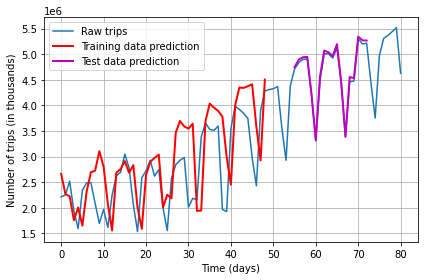

In [60]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(ine_trips)
trainPredictPlot[:] = np.nan
#trainPredictPlot[look_back+1:n_samples_train+1] = ine_hat_train
trainPredictPlot[:n_samples_train-look_back] = ine_hat_train
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(ine_trips)
testPredictPlot[:] = np.nan
#testPredictPlot[n_samples_train+1:len(ine_trips)-look_back+1] = ine_hat_test
testPredictPlot[n_samples_train-1:len(ine_trips)-(look_back)-1] = ine_hat_test
# plot baseline and predictions
plt.plot(trips_df['ine_trips'].values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Raw trips', 'Training data prediction', 'Test data prediction'), loc = 'upper left')
plt.grid(True)
#plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Time (days)", fontsize = 10)
plt.ylabel("Number of trips (in thousands)", fontsize = 10)
plt.tight_layout()
plt.savefig('var_ine_twt_pred.png')
plt.show()

In [ ]:
print("That's all folks!")